In [ ]:
!pip install nltk

In [ ]:
import nltk
import os
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import numpy as np
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.models import LsiModel
from gensim.models import HdpModel
from gensim.models import LdaMulticore
from gensim.models import EnsembleLda
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.utils import tokenize
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
nltk.download('wordnet')
import re
import json
import string
from bs4 import BeautifulSoup
from gensim.parsing.preprocessing import (
    strip_non_alphanum,
    split_alphanum,
    strip_short,
    strip_numeric
)
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
datafile = 'all_tickets.csv'
data = pd.read_csv(datafile)

In [ ]:
data.head(5)

title  \
0                                    NaN   
1                   connection with icon   
2                   work experience user   
3                 requesting for meeting   
4  reset passwords for external accounts   

                                                body  ticket_type  category  \
0  hi since recruiter lead permission approve req...            1         4   
1  icon dear please setup icon per icon engineers...            1         6   
2  work experience user hi work experience studen...            1         5   
3  requesting meeting hi please help follow equip...            1         5   
4  re expire days hi ask help update passwords co...            1         4   

   sub_category1  sub_category2  business_service  urgency  impact  
0              2             21                71        3       4  
1             22              7                26        3       4  
2             13              7                32        3       4  
3             13              7                32        3       4  
4              2             76                 4        3       4

In [ ]:
stop_words = stopwords.words('english')
custom_stop_words = ['hi', 'since', 'please', 'best', 'regards', 'thank', 'thanks', 'hello', 'sent', 'great', 'dear', 'help', 'kind']
time_words = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'today' , 'yesterday', 'tomorrow', 'hour', 'hours', 'time', 'times', 'timelines', 'date', 'day', 'days', 'am', 'pm', 'morning', 'noon', 'afternoon', 'evening', 'night', 'winter', 'summer', 'rain', 'cold']

def remove_stop_words(text):
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
    text = pattern.sub('', text)
    return text

def remove_custom_words(text):
    pattern = re.compile(r'\b(' + r'|'.join(custom_stop_words) + r')\b\s*')
    text = pattern.sub('', text)
    return text

def remove_time_words(text):
    pattern = re.compile(r'\b(' + r'|'.join(time_words) + r')\b\s*')
    text = pattern.sub('', text)
    return text

data['body'] = data["body"].map(lambda x: remove_stop_words(x))
data['Description'] = data["body"].map(lambda x: remove_custom_words(x))
data['body'] = data["body"].map(lambda x: remove_time_words(x))

In [ ]:
def parse_html(text, parser="html.parser"):
    soup = BeautifulSoup(text, parser)
    soup = remove_html_tags(soup)
    text = remove_multiple_space(soup.get_text()).strip()
    return text


def parse_html_v2(text, loop=2, parser="html.parser"):
    if not text:
        text = ""
    # some contents still have html code after first parse
    # loop solved problem
    for _ in range(loop):
        soup = BeautifulSoup(text, parser)
        text = soup.get_text()
    text = remove_multiple_space(text)
    return text


def remove_links_content(text):
    text = re.sub(r"http\S+", "", text)
    return text


def remove_emails(text):
    return re.sub('\S*@\S*\s?', '', text)  # noqa


def remove_punctuation(text):
    """https://stackoverflow.com/a/37221663"""
    table = str.maketrans({key: None for key in string.punctuation})
    return text.translate(table)


def remove_special_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('{.*?}')
    return re.sub(clean, '', text)


def preprocess_text(text):
    text = parse_html_v2(text)
    text = text.lower()
    text = remove_links_content(text)
    text = remove_emails(text)
    text = remove_special_tags(text)  # remove content between {}
    text = remove_punctuation(text)  # remove all puntuations
    text = split_alphanum(text)  # add space between word and numeric
    text = strip_numeric(text)  # remove digits
    text = strip_non_alphanum(text)  # remove non-alphabetic characters
    text = strip_short(text, minsize=2)  # remove word with length  <  minsize
    text = remove_multiple_space(text).strip()  # remove space and strip
    #text = tokenize(text)
    return text


def remove_multiple_space(text):
    return re.sub("\s\s+", " ", text)  # noqa


def remove_html_tags(soup,
                     tags=["script", "style"],
                     get_text=False):
    for tag in tags:
        for sample in soup.find_all(tag):
            sample.replaceWith('')

    if get_text:
        return soup.get_text()
    return soup

In [ ]:
# Convert body column to string for performing text operations
data['body'] = data['body'].astype(str)
data['body'] =data["body"].map(lambda x: preprocess_text(x))

In [ ]:
lemmatizer = WordNetLemmatizer()
data['Lemma_body'] = data["body"].map(lambda x: lemmatizer.lemmatize(x))

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


x = data['Lemma_body'].values.tolist()
docs = list(sent_to_words(x))
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

In [ ]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
#Remove rare & common tokens
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 8685
Number of documents: 48549
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1)]]


In [ ]:
# Set parameters.
num_topics = 5
chunksize = 500
passes = 20
iterations = 400
eval_every = 1

# Make a index to word dictionary.
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary

In [ ]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
data['Label'] = LE.fit_transform(data['category'])

In [ ]:
from sklearn.metrics import accuracy_score
def getLDAModelAccuracy(model, corpus, dataset, Label):
  get_document_topics = [model.get_document_topics(item) for item in corpus]
  np_array_of_objects = np.asarray(get_document_topics, dtype="object")
  pred_df = pd.DataFrame(columns=['pred_label'])
  length = len(pd.DataFrame(np_array_of_objects)[0])
  dict_list = []
  for i in range(0,length):
    count=len(pd.DataFrame(np_array_of_objects)[0][i])
    max=0
    for j in range(0,count):
      if(max < (pd.DataFrame(np_array_of_objects)[0][i])[j][1]):
        max=(pd.DataFrame(np_array_of_objects)[0][i])[j][1]
        label=(pd.DataFrame(np_array_of_objects)[0][i])[j][0]
    row_dict = {'pred_label': label}
    dict_list.append(row_dict)
  pred_df = pd.DataFrame.from_dict(dict_list)
  y_pred = pred_df['pred_label'].values
  y_true = dataset['Label'].values
  return(accuracy_score(y_true, y_pred))

In [ ]:
from sklearn.metrics import accuracy_score
def getModelAccuracy(model, corpus, dataset, Label):
  get_document_topics=model.__getitem__(corpus)
  #np_array_of_objects = np.asarray(get_document_topics, dtype="object")
  pred_df = pd.DataFrame(columns=['pred_label'])
  length = len(get_document_topics)
  dict_list = []
  for i in range(0,length):
    count=len(get_document_topics[i])
    maxvalue=0
    maxlabel=""
    for j in range(0,count):
      if(maxvalue < get_document_topics[i][j][1]):
        maxvalue=get_document_topics[i][j][1]
        maxlabel=get_document_topics[i][j][0]
    row_dict = {'pred_label': maxlabel}
    dict_list.append(row_dict)
  pred_df = pd.DataFrame.from_dict(dict_list)
  y_pred = pred_df['pred_label'].values
  y_true = dataset['Label'].values
  return(accuracy_score(y_true, y_pred))

In [ ]:
#nmf model
nmf_model = Nmf(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       w_max_iter=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 10 topics
print(nmf_model.print_topics())

[(0, '0.042*"receive_item" + 0.040*"purchase_po" + 0.036*"dear_purchased" + 0.033*"take_consideration" + 0.033*"section_order" + 0.033*"ordered_video" + 0.032*"mandatory_receipts" + 0.026*"log_allocation" + 0.025*"item" + 0.024*"purchase"'), (1, '0.068*"kind_regards" + 0.009*"analyst_ext" + 0.008*"ext" + 0.007*"sent" + 0.007*"importance_high" + 0.006*"analyst" + 0.005*"let" + 0.005*"hub" + 0.004*"help" + 0.004*"also"'), (2, '0.088*"leaver" + 0.033*"leaver_leaver" + 0.032*"leaver_form" + 0.030*"approver" + 0.020*"approver_approver" + 0.016*"location" + 0.016*"mailbox" + 0.015*"form" + 0.012*"mobile_phone" + 0.012*"name"'), (3, '0.036*"best_regards" + 0.015*"confluence" + 0.014*"best" + 0.009*"engineer" + 0.009*"senior_engineer" + 0.009*"senior" + 0.008*"sent" + 0.007*"kb" + 0.006*"importance_high" + 0.005*"issue"'), (4, '0.022*"error" + 0.014*"disk" + 0.013*"count" + 0.011*"sent" + 0.010*"cards" + 0.009*"failed" + 0.008*"expense_report" + 0.008*"submitted" + 0.008*"card" + 0.008*"count_

In [ ]:
c_v_coherence_model_nmf = CoherenceModel(model=nmf_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_nmf = c_v_coherence_model_nmf.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_nmf)


C_V Coherence Score:  0.5997159963871838


In [ ]:
u_mass_coherence_model_nmf = CoherenceModel(model=nmf_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_nmf = u_mass_coherence_model_nmf.get_coherence()
print('\nU_Mass Coherence Score: ', u_mass_coherence_nmf)


U_Mass Coherence Score:  -2.4083938071236544


In [ ]:
c_uci_coherence_model_nmf = CoherenceModel(model=nmf_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_nmf = c_uci_coherence_model_nmf.get_coherence()
print('\nc_uci Coherence Score: ', c_uci_coherence_nmf)


c_uci Coherence Score:  -2.772993056658126


In [ ]:
c_npmi_coherence_model_nmf = CoherenceModel(model=nmf_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_nmf = c_npmi_coherence_model_nmf.get_coherence()
print('\c_npmi_Coherence Score: ', c_npmi_coherence_nmf)

\c_npmi_Coherence Score:  -0.0391226332014382


In [ ]:
#lda model
lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 10 topics
print(lda_model.print_topics())

[(0, '0.018*"sent" + 0.012*"password" + 0.012*"error" + 0.009*"sa" + 0.008*"si" + 0.008*"laptop" + 0.008*"senior" + 0.007*"th_floor" + 0.007*"la" + 0.007*"senior_engineer"'), (1, '0.041*"sent" + 0.024*"kind_regards" + 0.020*"best_regards" + 0.018*"access" + 0.015*"issue" + 0.014*"could" + 0.014*"let_know" + 0.010*"en" + 0.009*"help" + 0.009*"manager"'), (2, '0.027*"annual_leave" + 0.023*"approval" + 0.019*"leave" + 0.019*"submit" + 0.017*"expense_report" + 0.014*"sent" + 0.012*"action" + 0.011*"annual" + 0.011*"expense" + 0.011*"submitted"'), (3, '0.021*"requisition" + 0.015*"mailbox" + 0.014*"po" + 0.012*"item" + 0.011*"dear_colleagues" + 0.011*"drive" + 0.011*"kind_regards" + 0.011*"items" + 0.011*"phone" + 0.010*"printer"'), (4, '0.064*"importance_high" + 0.030*"analyst_ext" + 0.023*"high" + 0.021*"importance" + 0.015*"sent_notification" + 0.011*"looking_forward" + 0.008*"information" + 0.008*"disk" + 0.008*"high_priority" + 0.008*"form"')]


In [ ]:
getLDAModelAccuracy(lda_model,corpus,data,"Label")

0.08904405857999136

In [ ]:
c_v_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_lda = c_v_coherence_model_lda.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_lda)


C_V Coherence Score:  0.4615068893437491


In [ ]:
u_mass_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence_model_lda.get_coherence()
print('\nU_Mass Coherence Score: ', u_mass_coherence_lda)


U_Mass Coherence Score:  -3.6085504334501373


In [ ]:
c_uci_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda = c_uci_coherence_model_lda.get_coherence()
print('\nc_uciCoherence Score: ', c_uci_coherence_lda)


c_uciCoherence Score:  -1.8421663652907


In [ ]:
c_npmi_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda = c_npmi_coherence_model_lda.get_coherence()
print('\c_npmi_Coherence Score: ', c_npmi_coherence_lda)

\c_npmi_Coherence Score:  -0.041347648144100704


In [ ]:
lsi_model = LsiModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       num_topics=num_topics)
# Print the Keyword in the 10 topics
print(lsi_model.print_topics())

[(0, '0.571*"kind_regards" + 0.292*"best_regards" + 0.192*"sent" + 0.133*"analyst_ext" + 0.128*"best" + 0.122*"importance_high" + 0.120*"confluence" + 0.119*"leaver" + 0.118*"ext" + 0.102*"engineer"'), (1, '-0.927*"confluence" + -0.347*"kb" + 0.078*"kind_regards" + 0.042*"best_regards" + 0.027*"sent" + -0.024*"tooling" + 0.021*"leaver" + -0.021*"holidays" + -0.018*"table" + 0.018*"best"'), (2, '-0.618*"leaver" + 0.267*"senior_consultant" + -0.237*"leaver_leaver" + -0.216*"leaver_form" + -0.211*"approver" + 0.198*"kind_regards" + 0.172*"senior" + -0.140*"approver_approver" + 0.135*"consultant" + -0.106*"mailbox"'), (3, '-0.710*"senior_consultant" + -0.433*"senior" + -0.354*"consultant" + -0.222*"leaver" + -0.159*"active" + 0.151*"kind_regards" + -0.096*"senior_engineer" + -0.086*"leaver_leaver" + -0.076*"leaver_form" + -0.075*"approver"'), (4, '-0.452*"changed" + -0.445*"interface" + -0.300*"senior_engineer" + -0.284*"link" + 0.240*"kind_regards" + -0.205*"protocol" + -0.191*"switch" + 

In [ ]:
c_v_coherence_model_lsi = CoherenceModel(model=lsi_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_lsi = c_v_coherence_model_lsi.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_lsi)


C_V Coherence Score:  0.3694251724091945


In [ ]:
u_mass_coherence_model_lsi = CoherenceModel(model=lsi_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lsi = u_mass_coherence_model_lsi.get_coherence()
print('\nu_mass Coherence Score: ', u_mass_coherence_lsi)


u_mass Coherence Score:  -3.1615132909749954


In [ ]:
c_uci_coherence_model_lsi = CoherenceModel(model=lsi_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lsi = c_uci_coherence_model_lsi.get_coherence()
print('\nc_uci Coherence Score: ', c_uci_coherence_lsi)


c_uci Coherence Score:  -1.8836149896855432


In [ ]:
c_npmi_coherence_model_lsi = CoherenceModel(model=lsi_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lsi = c_npmi_coherence_model_lsi.get_coherence()
print('\nc_npmi Coherence Score: ', c_npmi_coherence_lsi)


c_npmi Coherence Score:  -0.0706398532428245


In [ ]:
#hdp model
hdp_model = HdpModel(corpus=corpus, id2word=id2word, chunksize=chunksize)
# Print the Keyword in the 10 topics
print(hdp_model.print_topics())

[(0, '0.018*kind_regards + 0.012*best_regards + 0.007*importance_high + 0.005*best + 0.005*analyst_ext + 0.005*help + 0.005*ext + 0.005*site + 0.005*let + 0.004*also'), (1, '0.027*kind_regards + 0.011*best_regards + 0.009*receive_item + 0.009*purchase_po + 0.008*dear_purchased + 0.008*dear + 0.007*take_consideration + 0.007*section_order + 0.007*mandatory_receipts + 0.007*ordered_video'), (2, '0.027*sent + 0.014*kind_regards + 0.013*access + 0.010*let_know + 0.010*best_regards + 0.008*could + 0.008*issue + 0.007*manager + 0.006*error + 0.006*importance_high'), (3, '0.010*kind_regards + 0.009*sent + 0.007*best_regards + 0.006*message + 0.005*id + 0.005*server + 0.004*error + 0.004*version + 0.004*en + 0.004*information'), (4, '0.009*registered + 0.008*old_broad + 0.008*provide_clients + 0.008*registered_number + 0.008*street_kingdom + 0.008*whose_registered + 0.007*subsidiaries_separate + 0.007*information + 0.007*intended + 0.006*intended_solely'), (5, '0.062*leaver + 0.025*leaver_form

In [ ]:
c_v_coherence_model_hdp = CoherenceModel(model=hdp_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_hdp = c_v_coherence_model_hdp.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_hdp)


C_V Coherence Score:  0.40800898816207115


In [ ]:
u_mass_coherence_model_hdp = CoherenceModel(model=hdp_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_hdp = u_mass_coherence_model_hdp.get_coherence()
print('\nu_mass Coherence Score: ', u_mass_coherence_hdp)


u_mass Coherence Score:  -4.997181882336569


In [ ]:
c_uci_coherence_model_hdp = CoherenceModel(model=hdp_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_hdp = c_uci_coherence_model_hdp.get_coherence()
print('\nc_uci Coherence Score: ', c_uci_coherence_hdp)


c_uci Coherence Score:  -3.510857841693057


In [ ]:
c_npmi_coherence_model_hdp = CoherenceModel(model=hdp_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_hdp = c_npmi_coherence_model_hdp.get_coherence()

print('\nc_npmi Coherence Score: ', c_npmi_coherence_hdp)


c_npmi Coherence Score:  -0.11600377613634384


In [ ]:
#lda multicore model
lda_multicore_model = LdaMulticore(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 10 topics
print(lda_multicore_model.print_topics())

[(0, '0.027*"annual_leave" + 0.019*"leave" + 0.014*"submit" + 0.012*"action" + 0.011*"annual" + 0.011*"sent" + 0.010*"line_manager" + 0.010*"site" + 0.009*"approval" + 0.008*"action_required"'), (1, '0.021*"card" + 0.015*"cards" + 0.014*"requisition" + 0.013*"following_error" + 0.010*"status" + 0.010*"po" + 0.010*"approval" + 0.009*"lost_access" + 0.009*"submitted" + 0.009*"sent"'), (2, '0.038*"sent" + 0.019*"kind_regards" + 0.015*"access" + 0.013*"best_regards" + 0.012*"issue" + 0.012*"could" + 0.011*"let_know" + 0.011*"importance_high" + 0.010*"error" + 0.008*"help"'), (3, '0.013*"sa" + 0.013*"sent" + 0.012*"si" + 0.011*"senior" + 0.011*"best_regards" + 0.010*"la" + 0.010*"senior_engineer" + 0.009*"password" + 0.009*"engineer" + 0.007*"senior_developer"'), (4, '0.037*"analyst_ext" + 0.035*"th_floor" + 0.024*"phone" + 0.023*"floor" + 0.020*"meeting" + 0.019*"meeting_room" + 0.018*"th" + 0.013*"mailbox" + 0.012*"room" + 0.011*"leaver"')]


In [ ]:
getLDAModelAccuracy(lda_multicore_model,corpus,data,"Label")

0.0548723969597726

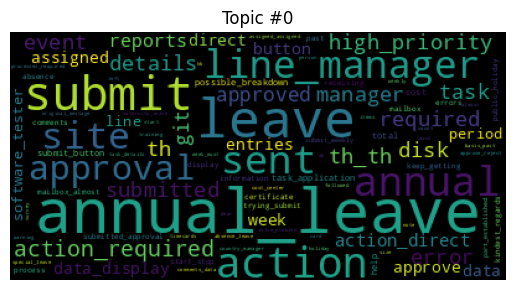

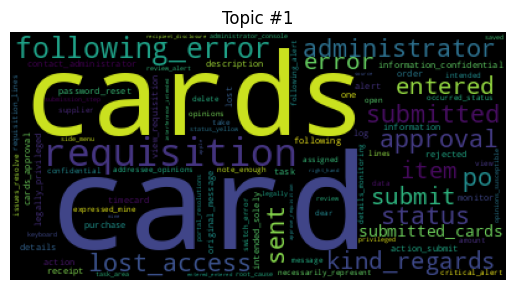

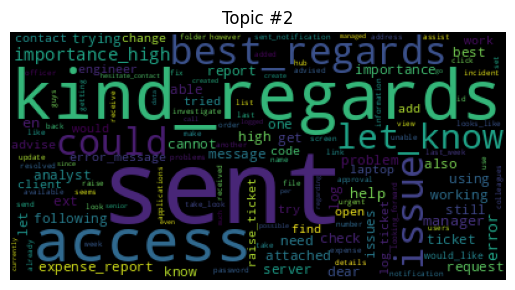

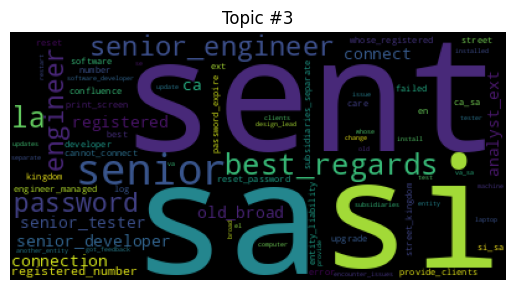

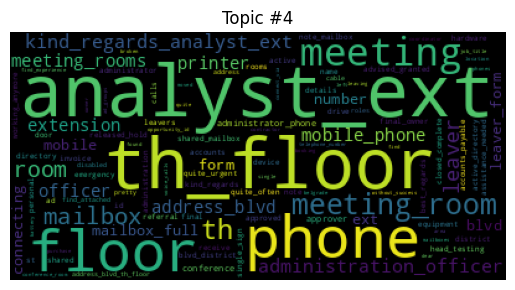

In [ ]:
for t in range(lda_multicore_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_multicore_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [ ]:
c_v_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_lda_multicore = c_v_coherence_model_lda_multicore.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_lda_multicore)


C_V Coherence Score:  0.41499100592640453


In [ ]:
u_mass_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda_multicore = u_mass_coherence_model_lda_multicore.get_coherence()
print('\nu_mass Coherence Score: ', u_mass_coherence_lda_multicore)


u_mass Coherence Score:  -3.9632170751783304


In [ ]:
c_uci_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda_multicore = c_uci_coherence_model_lda_multicore.get_coherence()
print('\nc_uci Coherence Score: ', c_uci_coherence_lda_multicore)


c_uci Coherence Score:  -3.034423396211898


In [ ]:
c_npmi_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda_multicore = c_npmi_coherence_model_lda_multicore.get_coherence()
print('\nc_npmi Coherence Score: ', c_npmi_coherence_lda_multicore)


c_npmi Coherence Score:  -0.07980130309005781


In [ ]:
#ensemble lda
ensemble_lda_model = EnsembleLda(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

In [ ]:
c_v_coherence_model_ensemble_lda = CoherenceModel(model=ensemble_lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_ensemble_lda = c_v_coherence_model_ensemble_lda.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_ensemble_lda)


C_V Coherence Score:  0.5129655221638285


In [ ]:
u_mass_coherence_model_ensemble_lda = CoherenceModel(model=ensemble_lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_ensemble_lda = u_mass_coherence_model_ensemble_lda.get_coherence()
print('\nu_mass Coherence Score: ', u_mass_coherence_ensemble_lda)


u_mass Coherence Score:  -2.637367919137554


In [ ]:
c_uci_coherence_model_ensemble_lda = CoherenceModel(model=ensemble_lda_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_ensemble_lda = c_uci_coherence_model_ensemble_lda.get_coherence()
print('\nc_uci Coherence Score: ', c_uci_coherence_ensemble_lda)


c_uci Coherence Score:  -2.753740648179784


In [ ]:
c_npmi_coherence_model_ensemble_lda = CoherenceModel(model=ensemble_lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_ensemble_lda = c_npmi_coherence_model_ensemble_lda.get_coherence()
print('\nc_npmi Coherence Score: ', c_npmi_coherence_ensemble_lda)


c_npmi Coherence Score:  -0.0242803366108899
